# Expansão de Consultas

### Autor: Hugo Gabriel

Neste trabalho estamos interessados em realizar a expansão de uma consulta do usuário, isto é, tendo o termo de consulta do usuário buscar outros termos semanticamente relacionados a este e expandir a busca com base nesse novo conjunto de termos.

Utilizaremos um modelo **Word2vec** para calcularmos a similaridade entre os termos e assim selecionar aqueles que farão parte da expansão, mais detalhes serão fornecidos ao longo do documento.

In [237]:
import pandas as pd
import numpy as np
import nltk
import unicodedata
import re
from textblob import TextBlob
from gensim import corpora, models, similarities
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.decomposition import PCA
from matplotlib import pyplot
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

## Visão Geral dos Dados

Contamos com uma base de dados de notícias relacionadas à política do jornal Estadão.

Vale ressaltar que as notícias não são recentes, visto que o timestamp de todas remete a 2014, isso deve ser levado em consideração na avaliação do modelo.

In [238]:
dados = pd.read_csv('../lab_01/data/estadao_noticias_eleicao.csv')
dados = dados.replace(np.nan, '', regex=True)

In [239]:
print("Os dados tem %d observações e %d colunas" % dados.shape)

Os dados tem 8716 observações e 6 colunas


In [240]:
dados.head()

,timestamp,titulo,subTitulo,conteudo,url,idNoticia
0,2014-12-31T00:00:00Z,PT espera 30 mil pessoas em festa na Esplanada,Objetivo é demonstrar apoio popular a Dilma e ...,BRASÍLIA - Após o desgaste provocado com o lan...,"http://politica.estadao.com.br/noticias/geral,...",1
1,2014-12-31T00:00:00Z,Alckmin toma posse de olho no Planalto,Governador reeleito tenta amarrar tucanos paul...,"Reeleito em outubro, o governador tucano Geral...","http://politica.estadao.com.br/noticias/geral,...",2
2,2014-12-31T00:00:00Z,Seis obstáculos e desafios do segundo mandato ...,"Em meio a escândalo de corrupção, presidente t...",1. Rearranjo das contas A nova equipe econôm...,"http://politica.estadao.com.br/noticias/geral,...",3
3,2014-12-31T00:00:00Z,,Veja as principais fotos do dia e dos eventos ...,,"http://fotos.estadao.com.br/fotos/politica,dil...",4
4,2014-12-31T00:00:00Z,,Veja as principais fotos do dia e dos eventos ...,,"http://fotos.estadao.com.br/fotos/politica,dil...",5


Como podemos ver os dados contém colunas para **título, subtítulo e conteúdo da notícia**, para a construção do modelo texto dessas colunas será agrupado em uma nova coluna **texto** que conterá toda a informação textual de uma notícia.

In [241]:
dados["text"] = dados["titulo"] + " " + dados["subTitulo"] + " " + dados["conteudo"]

In [242]:
dados.head()

,timestamp,titulo,subTitulo,conteudo,url,idNoticia,text
0,2014-12-31T00:00:00Z,PT espera 30 mil pessoas em festa na Esplanada,Objetivo é demonstrar apoio popular a Dilma e ...,BRASÍLIA - Após o desgaste provocado com o lan...,"http://politica.estadao.com.br/noticias/geral,...",1,PT espera 30 mil pessoas em festa na Esplanada...
1,2014-12-31T00:00:00Z,Alckmin toma posse de olho no Planalto,Governador reeleito tenta amarrar tucanos paul...,"Reeleito em outubro, o governador tucano Geral...","http://politica.estadao.com.br/noticias/geral,...",2,Alckmin toma posse de olho no Planalto Governa...
2,2014-12-31T00:00:00Z,Seis obstáculos e desafios do segundo mandato ...,"Em meio a escândalo de corrupção, presidente t...",1. Rearranjo das contas A nova equipe econôm...,"http://politica.estadao.com.br/noticias/geral,...",3,Seis obstáculos e desafios do segundo mandato ...
3,2014-12-31T00:00:00Z,,Veja as principais fotos do dia e dos eventos ...,,"http://fotos.estadao.com.br/fotos/politica,dil...",4,Veja as principais fotos do dia e dos eventos...
4,2014-12-31T00:00:00Z,,Veja as principais fotos do dia e dos eventos ...,,"http://fotos.estadao.com.br/fotos/politica,dil...",5,Veja as principais fotos do dia e dos eventos...


### Padronização do texto

São removidos do texto:

* Números
* Acentos
* Caracteres especiais
* Stopwords

Além disso o texto é todo colocado em caixa baixa.

Depois disso o texto de cada notícia é transformado em uma lista de palavras para que possa ser usado pelo modelo

In [243]:
def remove_stopwords (text):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [i for i in text.split() if not i in stopwords]
    return (" ".join(words))

def remove_numbers(text):
    return re.sub(r'[0-9]+', " ", text)

def standardize_text(text):
    text = text.lower()
    text = remove_stopwords(text)
    text = remove_special_caracters(text)
    text = remove_numbers(text)
    return text

def remove_special_caracters(palavra):
    nfkd = unicodedata.normalize('NFKD', palavra)
    palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])
    return re.sub('[^a-zA-Z0-9 \\\]', '', palavraSemAcento)

dados.text = dados.text.apply(standardize_text)

In [244]:
dados.head()["text"]

0    pt espera   mil pessoas festa esplanada objeti...
1    alckmin toma posse olho planalto governador re...
2    seis obstaculos desafios segundo mandato dilma...
3    veja principais fotos dia eventos especiais br...
4    veja principais fotos dia eventos especiais br...
Name: text, dtype: object

In [245]:
def get_palavras(data):
    palavras = []
    for index, row in data.iterrows():
        row["text"] = row["text"].lower()
        palavras_doc = TextBlob(row["text"]).words
        palavras.append(palavras_doc)
    return palavras

In [246]:
texts = get_palavras(dados)

## Modelo

Usaremos um modelo Word2Vec, nele cada palavra é representada como um vetor em um espaço vetorial n-dimensional, fazendo isso, podemos lançar mão de todo o arcabouço da álgebra vetorial para realizarmos operações com esses vetores (palavras) tais como soma, produto e cálculo de distância, deste modo, somos capazes de calcular a similaridade de palavras.

Foram desconsideradas palavras que apareçeram menos de 200 vezes no total de notícias, para evitar que o modelo considerasse palavras muito raras.

In [247]:
model = Word2Vec(texts, min_count=200)

O gráfico abaixo mostra as palavras usadas pelo modelo em um plano 2D.

Utilizamos o PCA (Principal component analysis) para reduzir a dimensionalidade dos dados e podermos ter a visualização dos mesmos.

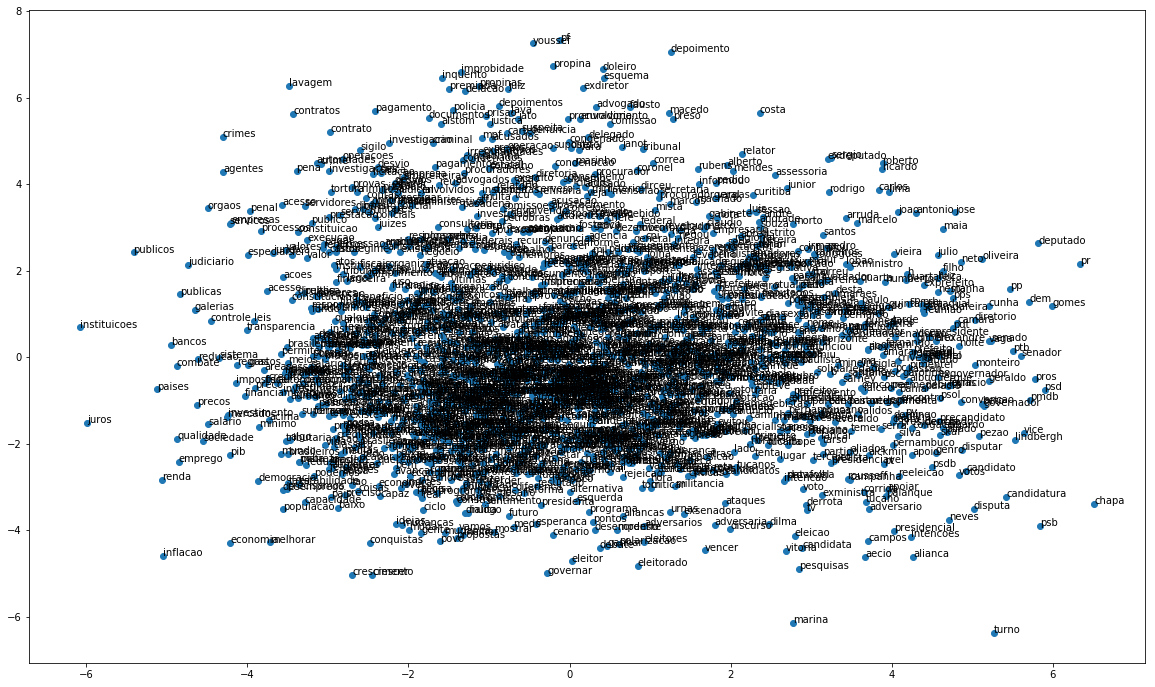

In [248]:
keys = list(model.wv.vocab.keys())
new_vocab = {}
for key in keys:
    new_vocab[key] = model.wv.vocab[key]
    
# fit a 2d PCA model to the vectors    
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.figure(figsize=(20, 12))
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

pyplot.show()

Logo aqui podemos ver, mesmo com a perda de informação por conta da redução de dimensionalidade, que palavras similares parecem estar próximas, como por exemplo:

* crescer e crescimento
* eleição, candidata, dilma e marina
* youssef, doleiro, propina e depoimento

Até aqui nosso modelo parece ser razoável para calcular a similaridade das palavras neste contexto. No entanto temos muitas palavras plotadas no mesmo gráfico o que dificuta a visualização, em função disso, visualizaremos agora um subconjunto de 500 palavras.

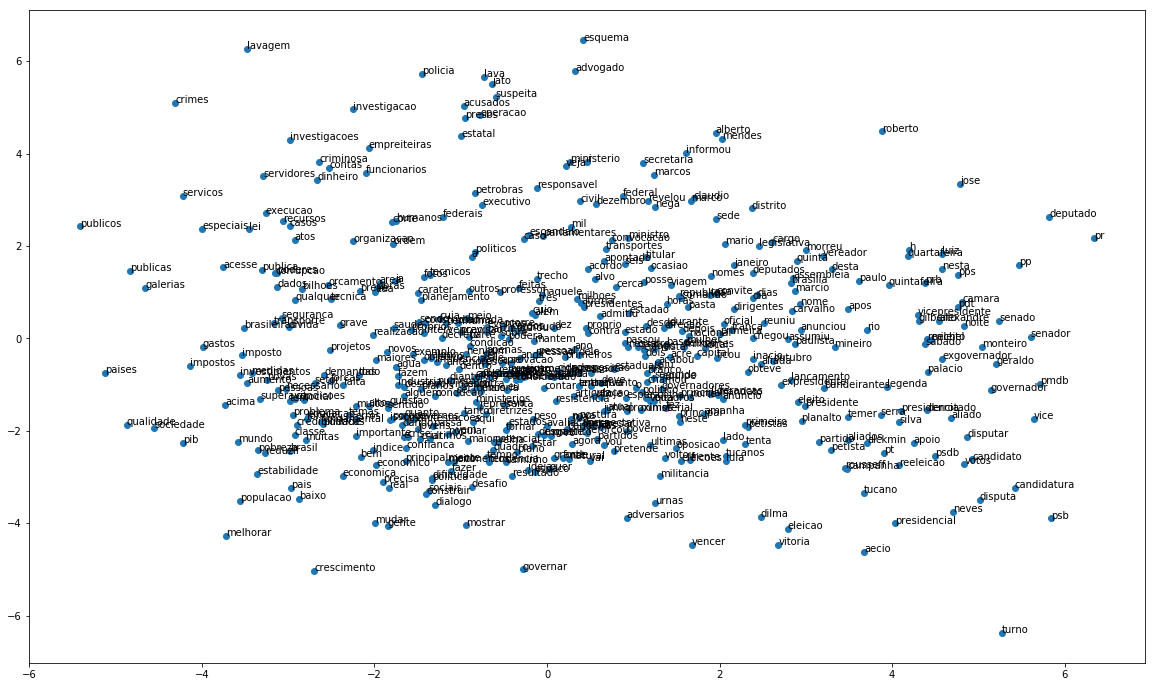

In [249]:
keys = list(model.wv.vocab.keys())
new_vocab = {}
for key in keys:
    new_vocab[key] = model.wv.vocab[key]
    
# fit a 2d PCA model to the vectors    
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)[:500]
# create a scatter plot of the projection
pyplot.figure(figsize=(20, 12))
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)[:500]
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

pyplot.show()

Essa visualização nos permite obter algumas outras informações mesmo que com menos dados.

As palavras parecem se agrupar também quanto ao assunto.

Termos ligados as **eleições** tais como: 

* Campanha
* Rousseff
* Aécio
* Candidatura
* Temer
* Partido
* Disputa
* e etc.

estão agrupados em uma área do gráfico.

Enquanto palavras que remetem aos **escândalos de corrupção** como por exemplo:

* Investigação
* Lavagem
* Criminosa
* Lava
* Jato
* Esquema
* Petrobrás
* e etc.

podem ser vistas em uma outra área da visualização.

Podemos consultar as **top 10 palavras** mais simlares à uma palavra de busca, ordenadas pela sua similaridade.

Por exemplo, podemos buscar **petrobras** e as palavras similares são:

In [250]:
result = model.wv.most_similar(positive=['petrobras'])
for r in result:
    print(r[0])

estatal
cervero
suspeitas
graca
foster
pasadena
irregularidades
companhia
diretoria
denuncias


Podemos ver que todas as palavras tem relevância para a busca da palavra petrobrás, já que a *Petrobrás* é uma **companhia** **estatal** que já tem um sua **diretoria** Nestor **Cerveró** e hoje é dirigida por **Graça Foster**. A empresa comprou uma refinaria em **Pasadena** (Texas-EUA) e foi/é alvo de várias **suspeitas** e **denúnica** de **irregularidades**.

## Testando Bi-gramas

Vamos testar um segundo modelo que considera não apenas palavras individuais mas também pares de palavras subsequentes, as *bigramas*, deste modo, espera-se que o modelo seja mais preciso em capturar informação de expressões como:

* Lava Jato
* Graça Foster
* Primeiro Turno

O modelo também será word2vec removendo palavras (e agora bigramas) que aparecem menos de 200 vezes.

In [251]:
bigram_transformer = Phraser(Phrases(texts))

model_bigram = Word2Vec(bigram_transformer[texts], min_count=200)

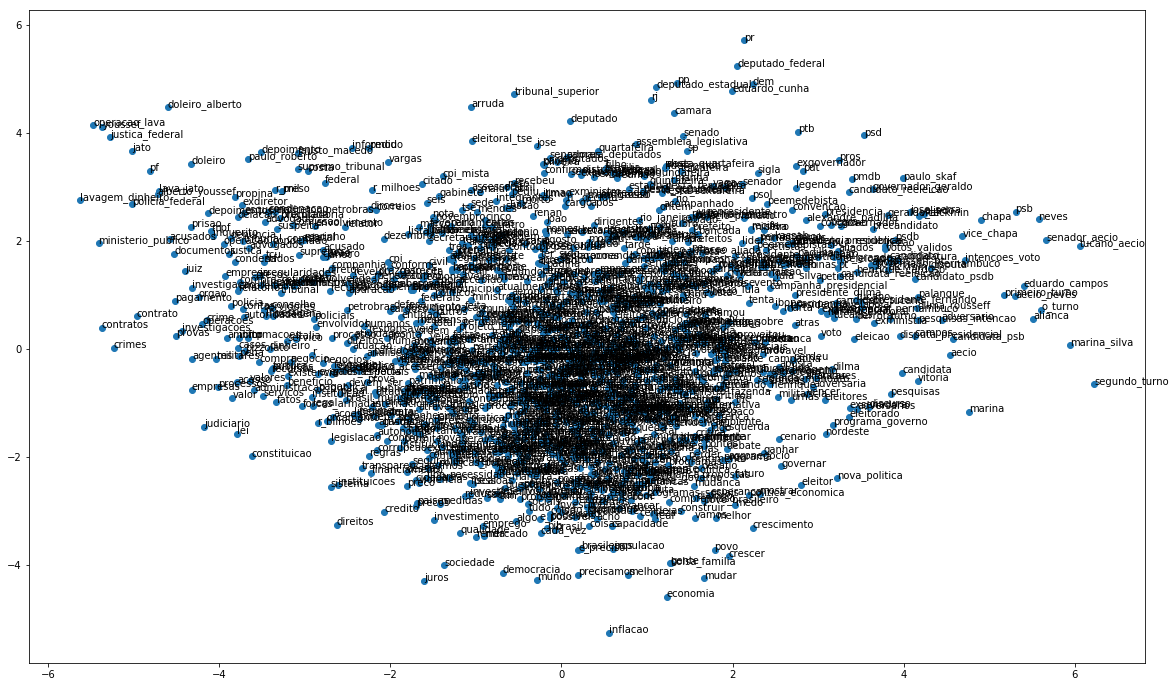

In [252]:
keys = list(model_bigram.wv.vocab.keys())
new_vocab = {}
for key in keys:
    new_vocab[key] = model_bigram.wv.vocab[key]
    
# fit a 2d PCA model to the vectors    
X = model_bigram[model_bigram.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.figure(figsize=(20, 12))
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model_bigram.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    
pyplot.show()

O modelo usado bigramas realmente é capaz de idenficar expessões como:

* Justiça Federal
* Senador Aécio
* Tucano Aécio
* Deputado Federal
* Marina Silva
* Lavagem de Dinheiro
* Ministério Público

sem desconsiderar as palavras individuais.

Ou seja, possivelmente, com as bigramas aumentamos o poder de expessividade semântica do modelo.

Realizando a mesma consulta (**petrobras**) neste novo modelo, obtemos:

In [253]:
result = model_bigram.wv.most_similar(positive=['petrobras'])
for r in result:
    print(r[0])

estatal
pasadena
compra_refinaria
cervero
negocio
exdiretor
denuncias
escandalo
compra
eua


Assim como o modelo anterior, todas as palavras em relação com o termo buscado.

### Top 3 palavras

Para a expansão da consulta, criamos a função a seguir que retorna as 3 palavras mais similares à palavra buscada, considerando o modelo tradicional (que não usa bigramas).

In [254]:
def busca_palavras_similares(palavra):
    palavra = standardize_text(palavra)
    result = model.wv.most_similar(positive=[palavra])
    
    return [result[0][0], result[1][0], result[2][0]]

#### Exemplos de Busca

In [255]:
print("lula -> ", busca_palavras_similares("lula"))
print("dilma -> ", busca_palavras_similares("dilma"))
print("eleicoes -> ", busca_palavras_similares("eleicoes"))

lula ->  ['inacio', 'fhc', 'luiz']
dilma ->  ['adversaria', 'reeleita', 'petista']
eleicoes ->  ['urnas', 'eleicao', 'pleito']


## Realizando Buscas

#### Índices Invertidos

Para realizar as buscas calcularemos os índices invertidos, que é o mapeamento de cada palavra aos documentos nos quais esta palavra aparece.

In [256]:
def calcula_indices_invertidos(data):
    indices = {}
    for index, row in data.iterrows():
        palavras = TextBlob(row["text"]).words
        
        for palavra in palavras:
            palavra_low = palavra.lower()
            if(palavra_low in indices):
                indices[palavra_low].add(row["idNoticia"])
            else:
                indices[palavra_low] = {row["idNoticia"]}
                
    return(indices)

indices_invertidos = calcula_indices_invertidos(dados)

#### Métodos de Busca

Consideramos a busca de um termo apenas e também a busca conjuntiva de 4 termos (1 termo original + 3 termos retornados pela expansão)

In [257]:
def busca_um_termo(termo):
    try:
        return(indices_invertidos[termo])
    except KeyError:
        return(set())

def busca_or(termo1, termo2, termo3, termo4):
    try:
        busca1 = indices_invertidos[termo1]
    except KeyError:
        busca1 = set()
        
    try:
        busca2 = indices_invertidos[termo2]
    except KeyError:
        busca2 = set()
        
    try:
        busca3 = indices_invertidos[termo3]
    except KeyError:
        busca3 = set()
    
    try:
        busca4 = indices_invertidos[termo4]
    except KeyError:
        busca4 = set()
        
    return(busca1 | busca2 | busca3 | busca4)

In [258]:
def busca(*args):
    if (len(args) != 4 and len(args) != 1):
        return("Número inválido de argumentos")
    elif(len(args) == 1):
        termo = args[0].lower()
        return(busca_um_termo(termo))
    elif(len(args) == 4):
        termo1 = args[0].lower()
        termo2 = args[1].lower()
        termo3 = args[2].lower()
        termo4 = args[3].lower()
        return(busca_or(termo1, termo2, termo3, termo4))

## Explansão das consultas

A função abaixo encapsula todo o processo de expansão da consulta e fornece um pequeno resumo.

São apresentados alguns exemplos de expansão.

In [259]:
def busca_word2vec(palavra):
    result_busca_palavra = busca(palavra)
    print("A busca pelo termo %s retorna %d documentos" % (palavra, len(result_busca_palavra)))
    t1, t2, t3 = busca_palavras_similares(palavra)
    print("Usando o modelo word2vec a consulta é extendida para os termos: \n\n%s\n%s\n%s\n" % (t1, t2, t3))
    result_busca_extendida = busca(palavra, t1, t2, t3)
    print("Resultando em %d documentos" % len(result_busca_extendida))
    print("Foram adicionados %d documentos ao retorno da consulta.\n" % (len(result_busca_extendida) - len(result_busca_palavra)))
    
    return [result_busca_palavra, result_busca_extendida]
    

### Busca 1 - Alckmin

In [260]:
busca_palavra, busca_extendida = busca_word2vec("alckmin")

A busca pelo termo alckmin retorna 653 documentos
Usando o modelo word2vec a consulta é extendida para os termos: 

geraldo
skaf
paulista

Resultando em 1240 documentos
Foram adicionados 587 documentos ao retorno da consulta.



A busca retorna:

* **Geraldo** que é o primero nome Alckmin
* **Skaf** que remete à Paulo Skaf, aliado político de Geraldo Alckmin
* **Kassab** que refere-se à Gilberto Kassab um outro aliado político

Interessante observar que o modelo foi capaz de capturar relacionamentos políticos já que as notícias se referem à eleições.

A busca comum retorna os seguintes documentos:

In [261]:
print(busca_palavra)

{2, 8201, 2060, 13, 2064, 8208, 2068, 21, 2069, 2070, 24, 8214, 26, 6170, 4124, 29, 2077, 2078, 4128, 6175, 38, 4135, 40, 2088, 6186, 45, 4154, 2112, 4161, 6210, 4166, 4172, 78, 4176, 87, 8280, 6233, 8281, 2140, 93, 2141, 4189, 2144, 6238, 6243, 100, 2148, 4197, 4199, 2152, 4200, 6244, 4203, 6248, 8306, 2164, 4217, 2170, 8313, 2176, 129, 4224, 2181, 2182, 6282, 139, 4236, 2191, 2193, 8338, 153, 8354, 4263, 6313, 6314, 180, 8373, 6326, 8376, 8377, 2234, 4282, 8380, 8383, 2241, 4293, 2246, 2253, 2257, 2260, 8404, 2268, 8414, 8417, 8418, 2284, 4336, 2292, 2293, 4340, 2295, 2296, 8436, 259, 6407, 264, 269, 6415, 8466, 6430, 2337, 8481, 8484, 2347, 8494, 8495, 4401, 6449, 6451, 2356, 8503, 6461, 4414, 2367, 8512, 8513, 2370, 4419, 8514, 8515, 2375, 6473, 8525, 8527, 4435, 4441, 4444, 4445, 2399, 2401, 8549, 4456, 6507, 8556, 8561, 8215, 2422, 2427, 8571, 4479, 8577, 4487, 4490, 4491, 8588, 2447, 2456, 4505, 8601, 2463, 8609, 6562, 8610, 8612, 4518, 6571, 8634, 8635, 2492, 2493, 2494, 4550, 

Já a consulta extendida retorna:

In [262]:
print(busca_extendida)

{2, 8195, 7, 8201, 13, 8208, 17, 21, 8214, 8215, 24, 8217, 26, 8218, 4124, 29, 4126, 4128, 4129, 8225, 38, 4135, 40, 45, 4148, 8244, 4150, 4154, 4156, 4158, 4161, 8261, 4166, 75, 4172, 77, 78, 4176, 8274, 87, 8280, 8281, 8284, 93, 4189, 8286, 8288, 97, 4193, 4195, 100, 4197, 4196, 4199, 4200, 8289, 4203, 4204, 110, 8306, 4212, 4216, 4217, 8313, 4218, 4222, 4223, 4224, 129, 4229, 8326, 4231, 136, 139, 4236, 8338, 146, 4243, 8340, 8341, 153, 4252, 157, 8351, 4256, 8354, 8357, 4263, 4268, 8368, 178, 180, 8373, 8376, 8377, 4282, 8380, 4285, 8383, 8384, 4293, 4296, 8399, 8402, 210, 8404, 8403, 8407, 216, 8412, 8414, 8416, 8417, 8418, 4326, 4327, 235, 4332, 237, 8431, 4336, 239, 8435, 4340, 8436, 244, 259, 8451, 264, 4361, 8456, 269, 8465, 8466, 4371, 4380, 4382, 8480, 8481, 4387, 8484, 4388, 8494, 8495, 4401, 8503, 8506, 4414, 4415, 8512, 8513, 8514, 4419, 8515, 8525, 8527, 4435, 4441, 8537, 4444, 4445, 4446, 8549, 4456, 363, 8556, 8561, 8571, 382, 4479, 8577, 4483, 4484, 4487, 4488, 4489, 

### Busca 2 - Lula

In [263]:
busca_palavra, busca_extendida = busca_word2vec("lula")

A busca pelo termo lula retorna 1891 documentos
Usando o modelo word2vec a consulta é extendida para os termos: 

inacio
fhc
luiz

Resultando em 2496 documentos
Foram adicionados 605 documentos ao retorno da consulta.



A busca retorna:

* **Inácio** que é o nome de Lula (Luiz Inácio)
* **FHC** que refere-se à Fernando Henrique Cardoso, que assim como Lula foi presidente do Brasil
* **Luiz** que é o nome de Lula (Luiz Inácio)

A consulta retorna os seguintas documentos:

In [264]:
print(busca_palavra)

{1, 2, 3, 8197, 8198, 14, 15, 16, 18, 8213, 8214, 23, 8218, 28, 8220, 33, 34, 8225, 37, 39, 40, 41, 43, 46, 8245, 54, 60, 8258, 69, 8261, 8264, 74, 75, 80, 8272, 8273, 83, 8274, 85, 8277, 89, 8282, 97, 98, 8289, 8290, 102, 106, 8305, 125, 128, 8322, 8323, 133, 8328, 8333, 8335, 8337, 146, 147, 8342, 154, 8349, 158, 8350, 8352, 8355, 165, 8361, 8365, 178, 8375, 8379, 8390, 8395, 8396, 8397, 216, 217, 220, 8415, 224, 225, 8418, 8420, 8421, 232, 8424, 248, 250, 252, 8448, 8451, 8457, 8459, 270, 8462, 272, 8465, 8467, 8471, 8472, 8473, 8474, 8475, 285, 8478, 289, 290, 8481, 8487, 8489, 8496, 305, 8498, 307, 8499, 8501, 8502, 8503, 314, 8512, 325, 8522, 335, 8530, 340, 8538, 347, 8543, 8544, 354, 356, 357, 8552, 8555, 8561, 370, 8562, 8566, 375, 8575, 8576, 391, 392, 8588, 8589, 403, 404, 8595, 407, 8599, 8601, 411, 412, 8607, 426, 8624, 437, 8630, 440, 444, 8641, 450, 8643, 456, 457, 8649, 8658, 469, 474, 8666, 480, 8673, 482, 495, 498, 499, 500, 502, 503, 504, 8698, 508, 8700, 513, 8707, 

Enquanto a busca extendida:

In [265]:
print(busca_extendida)

{1, 2, 3, 8197, 8198, 11, 12, 14, 15, 16, 18, 8213, 8214, 23, 25, 8218, 8217, 28, 8220, 33, 34, 8225, 35, 37, 39, 40, 41, 43, 46, 8245, 54, 8249, 60, 8258, 69, 8261, 8264, 74, 75, 78, 80, 8272, 8273, 83, 8274, 85, 8277, 87, 89, 8282, 8284, 8286, 8288, 97, 98, 8289, 8290, 102, 105, 106, 110, 8305, 113, 114, 8306, 120, 8313, 125, 8319, 128, 8322, 8323, 8324, 133, 8328, 8332, 8333, 8335, 8337, 146, 147, 8342, 152, 153, 154, 155, 8349, 158, 8350, 8352, 8354, 8355, 163, 165, 8356, 168, 8361, 8365, 178, 179, 180, 8375, 8379, 187, 8383, 8390, 8395, 8396, 8397, 8404, 216, 217, 220, 8414, 8415, 224, 225, 8418, 8417, 8420, 8421, 231, 232, 8424, 8430, 8435, 248, 250, 252, 8448, 8451, 8457, 8459, 270, 8462, 272, 8465, 8467, 8471, 8472, 8473, 8474, 8475, 285, 8478, 289, 290, 8481, 8484, 8487, 296, 8489, 8490, 8493, 8496, 305, 8498, 307, 8499, 8501, 8502, 8503, 314, 8506, 8512, 325, 8519, 8522, 335, 8530, 340, 342, 8536, 8538, 347, 8542, 8543, 8544, 354, 8547, 356, 357, 8552, 8555, 363, 8561, 370, 8

### Busca 3 - Lava

Essa busca é interessante pois a palavra **lava** não parece ter muito significado semântico, mas quando condideramos que estamos no contexto de política no Brasil sabemos que ela tem muito sentido e estamos interessados em saber se o modelo foi capaz de capturar isso.

In [266]:
busca_palavra, busca_extendida = busca_word2vec("lava")

A busca pelo termo lava retorna 503 documentos
Usando o modelo word2vec a consulta é extendida para os termos: 

operacao
jato
pf

Resultando em 985 documentos
Foram adicionados 482 documentos ao retorno da consulta.



Realmente o modelo foi capaz de capturar palavras semânticamentes próximas, como podemos constatar já que: 

* A *Lava* **Jato** é uma **operação** da Polícia Federal (**PF**)

A consulta retorna os seguintas documentos:

In [267]:
print(busca_palavra)

{3, 13, 15, 27, 6177, 43, 46, 48, 50, 51, 59, 61, 6205, 64, 6209, 6214, 72, 79, 80, 81, 86, 92, 95, 98, 99, 101, 102, 105, 106, 6253, 6254, 113, 117, 2166, 2167, 120, 122, 123, 127, 2175, 137, 2185, 143, 147, 149, 150, 151, 152, 155, 156, 163, 164, 167, 173, 178, 179, 182, 183, 185, 192, 196, 197, 201, 208, 211, 213, 214, 223, 6368, 6372, 231, 241, 242, 245, 2297, 250, 2302, 258, 260, 6408, 265, 268, 6413, 271, 273, 6417, 277, 281, 292, 2340, 4389, 4390, 298, 4394, 4396, 301, 305, 306, 314, 6460, 4416, 4418, 323, 6466, 6467, 326, 327, 4424, 6481, 2389, 342, 343, 6490, 2395, 348, 350, 351, 353, 354, 356, 4452, 358, 2407, 359, 360, 361, 362, 4459, 367, 368, 370, 4473, 6527, 2439, 392, 6538, 397, 4497, 6548, 6549, 406, 4503, 408, 4505, 4508, 418, 419, 422, 2471, 4521, 429, 430, 433, 434, 435, 438, 441, 442, 443, 452, 454, 464, 465, 468, 474, 476, 2525, 480, 6626, 483, 4580, 485, 488, 2540, 4588, 495, 499, 502, 503, 504, 505, 508, 6654, 511, 513, 514, 516, 518, 2570, 523, 526, 527, 6671, 6

In [268]:
print(busca_extendida)

{3, 7, 13, 4109, 15, 6160, 8209, 8208, 22, 27, 6172, 6177, 6184, 6185, 2090, 43, 6188, 46, 6191, 48, 50, 51, 4150, 6199, 59, 61, 8254, 6205, 64, 6206, 6209, 8259, 68, 6214, 72, 79, 80, 81, 86, 6235, 92, 95, 98, 99, 101, 102, 105, 106, 6253, 6254, 6255, 113, 8306, 117, 2166, 2167, 120, 121, 122, 123, 8313, 127, 128, 8319, 8320, 2175, 8324, 2181, 4224, 2184, 137, 2185, 143, 147, 149, 150, 151, 152, 6293, 153, 155, 156, 163, 164, 167, 6312, 170, 8362, 8364, 173, 6316, 178, 179, 8371, 8372, 182, 183, 2232, 185, 187, 2237, 192, 196, 197, 4293, 4296, 201, 8399, 208, 8402, 211, 213, 214, 6360, 6361, 2266, 2268, 223, 6368, 6372, 8421, 231, 8431, 241, 242, 6386, 245, 246, 2294, 2297, 250, 2300, 2301, 2302, 6398, 258, 260, 6407, 6408, 265, 8457, 4363, 268, 8461, 270, 271, 6413, 273, 6415, 6417, 277, 281, 2329, 283, 6429, 8478, 8479, 4384, 289, 8480, 4386, 292, 4389, 4390, 2340, 4388, 2341, 298, 4394, 4396, 301, 8488, 8494, 8495, 305, 306, 6449, 8497, 4405, 311, 314, 315, 316, 6460, 319, 4416, 23

Em função do grande número de documentos retornados o texto dos documentos não poderá ser analisado individualmente.


### Outros exemplos de Busca:

In [269]:
a, b = busca_word2vec("deputado")

A busca pelo termo deputado retorna 1790 documentos
Usando o modelo word2vec a consulta é extendida para os termos: 

deputada
exdeputado
distrito

Resultando em 2226 documentos
Foram adicionados 436 documentos ao retorno da consulta.



In [270]:
a, b = busca_word2vec("morte")

A busca pelo termo morte retorna 571 documentos
Usando o modelo word2vec a consulta é extendida para os termos: 

acidente
morto
morreu

Resultando em 1002 documentos
Foram adicionados 431 documentos ao retorno da consulta.



In [271]:
a, b = busca_word2vec("dilma")

A busca pelo termo dilma retorna 4269 documentos
Usando o modelo word2vec a consulta é extendida para os termos: 

adversaria
reeleita
petista

Resultando em 4639 documentos
Foram adicionados 370 documentos ao retorno da consulta.



## Conclusões

Podemos ver que todos os temos retornados pela busca expandida tem relação com o termo buscado (tanto no modelo simples quanto no com bigramas).

Observamos ainda que a expansão de consultas é capaz de melhorar a *recall* do índice de busca uma vez que são retornados mais documentos realmente ligados à pesquisa.